In [1]:
import pandas as pd
import geopandas as gpd
import statsmodels.api as sm
from function import spearman_corr_heatmap

import warnings
warnings.simplefilter(action='ignore')

In [2]:
df = pd.read_csv("../00_data/13_final/cbsa_level.csv")
gdf = gpd.read_file("../00_data/01_raw/tl_2024_us_cbsa", engine="pyogrio")
gdf['cbsacode'] = gdf['CBSAFP'].astype('float64')

In [3]:
gdf["ALAND_acres"] = gdf["ALAND"] / 4046.8564224
df = df.merge(gdf[['ALAND_acres','cbsacode']],how='left')
df['density'] = df["TotalPopulation"]/df["ALAND_acres"]

In [4]:
df

,cbsacode,TotalPopulation,BINGE,CSMOKING,DEPRESSION,DIABETES,LPA,OBESITY,adult_smoking,adult_obesity,...,coverage_80,coverage_90,noise50n,noise60n,noise70n,noise80n,noise90n,Park_Area_Acres,ALAND_acres,density
0,10100.0,42037,8802.089,5942.090,7630.409,3886.342,9800.073,14822.801,5446.675000,11129.643000,...,131.000000,22.000000,3717.083034,607.189173,44.967758,6.824776,3.068829,550.773301,1.816967e+06,0.023136
1,10140.0,77038,12865.346,11555.700,20954.336,9937.902,19105.424,28427.022,11515.519999,21818.879999,...,55.000000,10.000000,3744.330966,733.378889,107.629504,7.306492,1.801527,104080.141400,1.216937e+06,0.063305
2,10180.0,179308,33724.319,27437.232,43682.746,22629.731,49045.578,64315.187,22934.902001,48604.362001,...,1426.114687,167.000000,19453.578040,5776.179243,1259.546092,134.775549,21.393130,3252.752494,1.755849e+06,0.102120
3,10220.0,38141,5263.458,7475.636,11327.877,5377.881,12433.966,16400.630,6250.512000,10719.336000,...,75.000000,3.000000,2481.170945,552.701071,101.550631,3.799527,0.091602,87.794807,4.610259e+05,0.082731
4,10300.0,98567,16559.256,16066.421,23754.647,11335.205,26021.688,41496.707,15798.168001,30589.590001,...,88.000000,14.000000,5334.595050,801.912541,59.860893,7.036913,0.545557,741.377599,4.797683e+05,0.205447
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
870,49660.0,426279,70236.063,90823.818,107573.664,67051.467,128537.013,177133.518,84594.889997,129905.928995,...,803.310003,111.310003,35991.149063,8202.722856,1981.787831,130.858132,15.124541,5621.076757,6.586099e+05,0.647240
871,49700.0,182813,33171.767,28898.647,41820.750,22149.607,48250.135,58527.698,19167.600000,39108.972000,...,575.389126,128.000000,24140.378031,6757.409025,2719.702058,85.952259,11.647516,888.207710,7.902092e+05,0.231348
872,49740.0,207842,35748.824,27642.986,40529.190,32215.510,65054.546,84176.010,24739.689001,62914.176003,...,414.522018,81.197429,42701.812167,7451.757500,835.325759,24.067545,3.407328,434.539877,3.528844e+06,0.058898
873,49780.0,86113,15328.114,16533.696,22217.154,12141.933,24628.318,35392.443,17409.743999,26281.375999,...,341.873003,29.000000,5791.755148,1330.386560,353.883381,27.677967,1.952414,15833.810080,4.253093e+05,0.202471


In [5]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

rows = []

id_col = "cbsacode"
pop_col = "density"

# factors: all numeric except ID and population
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
factors = [c for c in numeric_cols if c not in [id_col, pop_col]]

for factor in factors:
    # keep only observations with positive Y and N for logs
    valid = (df[factor] > 0) & (df[pop_col] > 0)
    if valid.sum() < 3:
        continue  # not enough data points to fit

    y_log = np.log(df.loc[valid, factor])
    X = sm.add_constant(np.log(df.loc[valid, pop_col]))
    X.columns = ["const", f"log_{pop_col}"]

    model = sm.OLS(y_log, X).fit()

    # fitted log Y and SAMI (log residuals)
    yhat_log = model.predict(X)
    sami = y_log - yhat_log

    # slope & stats
    beta = model.params[f"log_{pop_col}"]
    pval = model.pvalues[f"log_{pop_col}"]
    ci_low, ci_up = model.conf_int().loc[f"log_{pop_col}"]
    logY0_hat = model.params["const"]

    # append one row per CBSA in the valid set
    for i, cbsa in df.loc[valid, id_col].items():
        rows.append({
            "cbsacode": cbsa,
            "factor": factor,
            "SAMI": float(sami.loc[i]),       # ξ_i = log-residual
            "beta": float(beta),
            "p_value": float(pval),
            "CI_lower": float(ci_low),
            "CI_upper": float(ci_up),
            "logY0_hat": float(logY0_hat),
            "n_used": int(valid.sum()),
            "r2": float(model.rsquared)
        })

results_df = pd.DataFrame(rows)

In [6]:
results_df.to_csv('../00_data/14_output/SAMIs_den.csv')

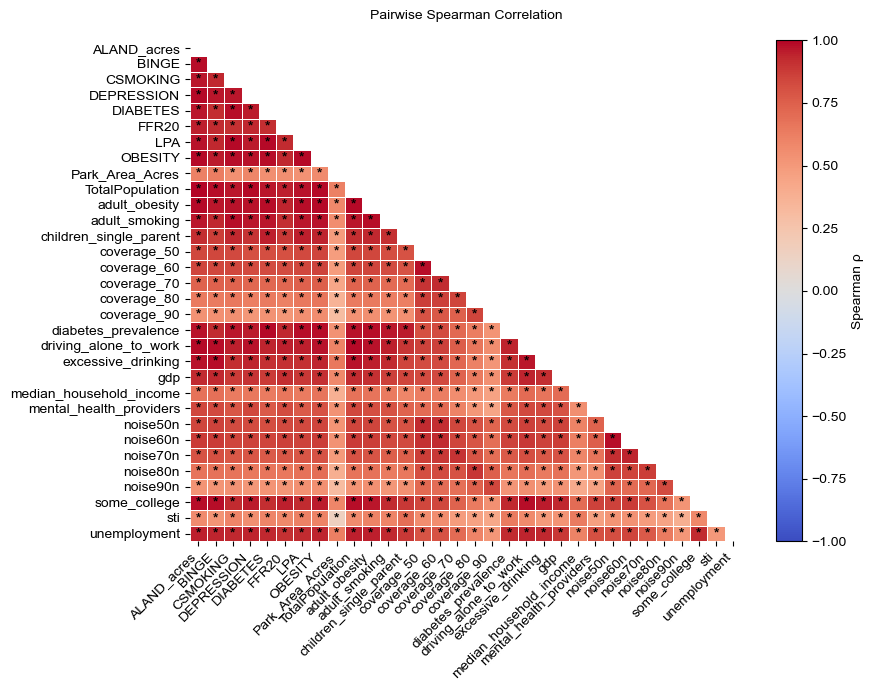

In [7]:
sami_wide = results_df.pivot(index="cbsacode", columns="factor", values="SAMI")

cols = [c for c in sami_wide.columns if c not in ['cbsacode']]
corr, pvals = spearman_corr_heatmap(sami_wide, columns=cols,figsize=(9, 7), savepath=None)